In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs_revised.preprocessing import *
from custom_classes_defs_revised.Unet_like import *
#from custom_classes_defs_revised.unet import *
#from custom_classes_defs_revised.fnet0 import *


RND_STATE = 247
BATCH_SIZE = 512
EPOCH_SIZE = 4

keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

### Data preparation and model configurations

---------------

In [4]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.16.1
keras version: 3.0.5
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
seis_path = "data_preprocessing/data_download/full_data/temp/temp_stacked/seismic/"
label_path = "data_preprocessing/data_download/full_data/temp/temp_stacked/fault/"

In [6]:
time_start= time.time()
thebe_data = Thebe(seis_path,label_path,ratio = 1)

train_dataset = thebe_data.data_generator(sub_group='train',cache=False)
val_dataset = thebe_data.data_generator(sub_group='val',as_numpy=True, cache= False)
test_dataset = thebe_data.data_generator(sub_group='test',as_numpy=True,cache= False)

time_end = time.time()-time_start
print(f'Loading time used in {time_end} sec')

Loading time used in 0.5047934055328369 sec


In [7]:
### Interactive step:
#if INTERACTIVE_SESSION:
#    train = input("New train session? (y/n): ")
#    if train[0].lower()=='y':
#        conf.new_training_session = True
#    else:
#        conf.new_training_session = False
#    interact = input("Are you sure, you want to run this session interactively? (y/n): ")
#    if interact[0].lower()!='y':
#        INTERACTIVE_SESSION = False

In [8]:
# Model configurations
conf = model_config(
    epochs=EPOCH_SIZE,
    batch_size=BATCH_SIZE,
    scaling=1,
    verbose=1,
    save_path='data_preprocessing/data_download/full_data/temp/output',
    img_shape=(96,96),
    target_size=(96,96),
    #augmentation = True,
    new_training_session=True,
    channels_dim=(1,1),
    pos_label= thebe_data.pos_label,
    mixed_precision = False,
    multiple_gpu_device=(NUM_GPU>1)
)

#callbacks=conf.callbacks(chkpt_monitor='val_loss', lr_patience= 5, lr_factor=0.5,)

callbacks=conf.callbacks(chkpt_monitor='val_loss', es_monitor='val_loss',
    es_patience=15, 
    lr_monitor='val_loss',
    lr_patience=5,)

conf.set( validation_data=val_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.Adam(1e-3), 
    metrics= ['accuracy']
)
# changed learning rate to default e-3

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 0
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: <class 'keras.src.optimizers.adam.Adam'>
                          loss: binary_crossentropy
                       metrics: accuracy
           img_shape: (96, 96)
              labels: [0, 1]
     mixed_precision: False
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: data_preprocessing/data_download/full_data/temp/output
             scaling: 1
         target_size: (96, 96)
           test_size: None
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 4
                    batch_size: 512
                       shuffle: False
       

### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        # m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")



	Build model
-------------------------------------------------------
Total number of parameters: 2,057,825
Total trainable wieghts: 2,054,049
Total non-trainable wieghts: 3,776


### Train and evaluate  model



	Train unet model
-------------------------------------------------------
Model training...
Epoch 1/4
6001/6001 ━━━━━━━━━━━━━━━━━━━━ 186s 30ms/step - accuracy: 0.8844 - loss: 1.8527 - val_accuracy: 0.8519 - val_loss: 1.6890 - learning_rate: 0.0010
Epoch 2/4
6001/6001 ━━━━━━━━━━━━━━━━━━━━ 180s 30ms/step - accuracy: 0.8852 - loss: 1.8511 - val_accuracy: 0.8513 - val_loss: 1.6918 - learning_rate: 0.0010
Epoch 3/4
6001/6001 ━━━━━━━━━━━━━━━━━━━━ 180s 30ms/step - accuracy: 0.8852 - loss: 1.8511 - val_accuracy: 0.8525 - val_loss: 1.6857 - learning_rate: 0.0010
Epoch 4/4
6001/6001 ━━━━━━━━━━━━━━━━━━━━ 180s 30ms/step - accuracy: 0.8852 - loss: 1.8511 - val_accuracy: 0.8519 - val_loss: 1.6886 - learning_rate: 0.0010
training elapsed time: ___12.10___ minutes
...training completed!


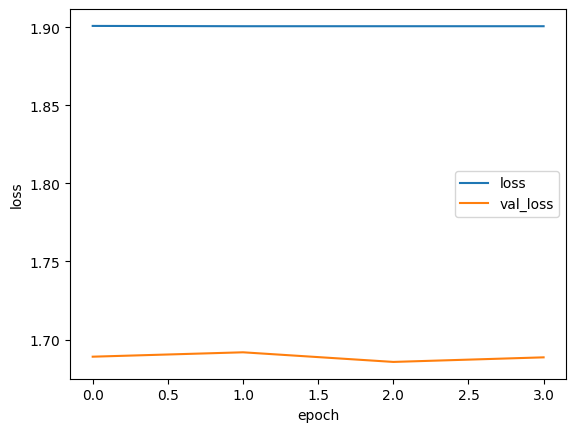

AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'

In [10]:
time_start= time.time()

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)

time_end = time.time()-time_start
print(f'Loading time used in {time_end} sec')

In [ ]:
#show_convergence(train_history.history, ['accuracy','val_accuracy'])

In [ ]:
#show_convergence(train_history.history, 'lr')

### Visualize predictions

In [11]:
def plot_random_images(images, labels, num_images=4):
    num_total_images = len(images)
    random_indices = np.random.choice(num_total_images, size=num_images, replace=False)
    
    fig, axes = plt.subplots(3, num_images, figsize=(18, 10))
    
    # Plot overlapped images
    for i, idx in enumerate(random_indices):
        axes[0, i].imshow(images[idx], cmap='seismic', aspect='auto')
        axes[0, i].imshow(labels[idx], cmap='gray', aspect='auto',alpha=0.3)
        axes[0, i].set_title(f"seismic id: {idx}")
        axes[0, i].axis('off')
        
    # Plot labels
    for i, idx in enumerate(random_indices):
        axes[1, i].imshow(labels[idx],cmap='gray', aspect='auto')
        axes[1, i].set_title(f"label id: {idx}")
        axes[1, i].axis('off')
    
    # Plot original images
    for i, idx in enumerate(random_indices):
        axes[2, i].imshow(images[idx], cmap='seismic', aspect='auto')
        axes[2, i].axis('off')
        axes[2, i].set_title(f"original seismic: {idx}")
        
    
    plt.tight_layout()
    plt.show()

### prediction 

In [ ]:
plot_random_images(val_dataset[0],val_dataset[1],num_images=4)

In [12]:
if INTERACTIVE_SESSION == True:
    y_preds = model.predict(test_dataset[0])
print(y_preds.shape)

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step
(1201, 96, 96, 1)


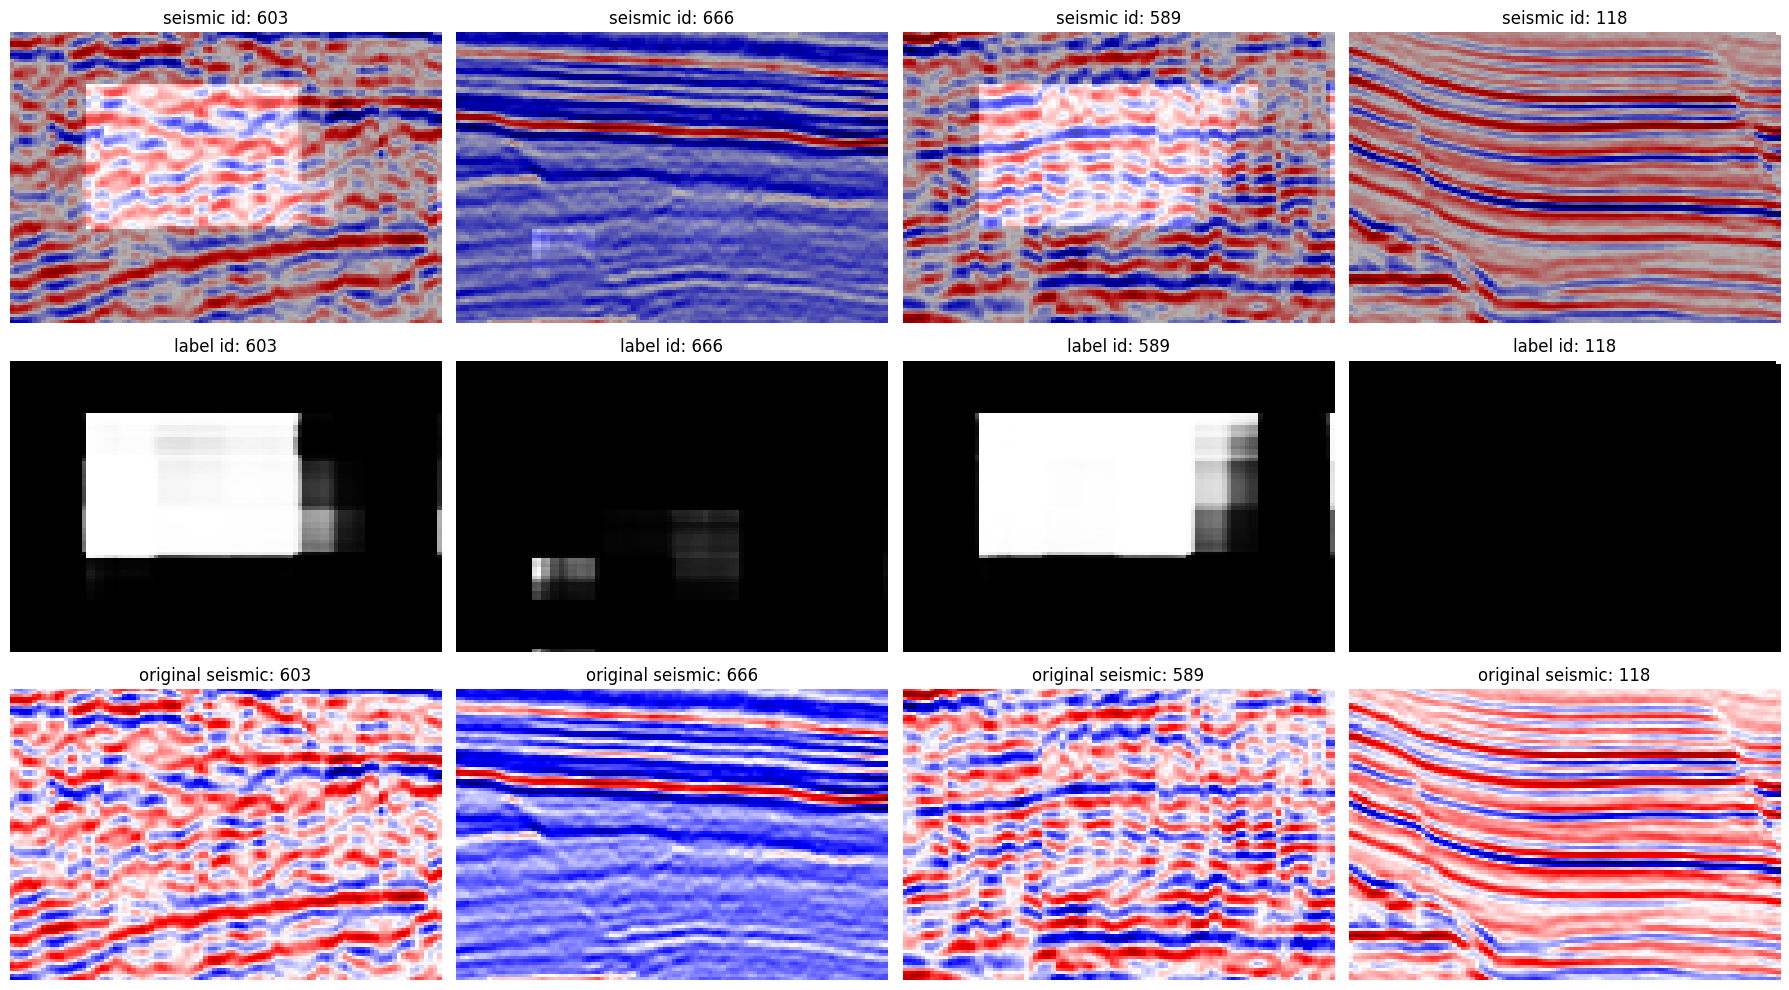

In [13]:
plot_random_images(test_dataset[0],y_preds,num_images=4)

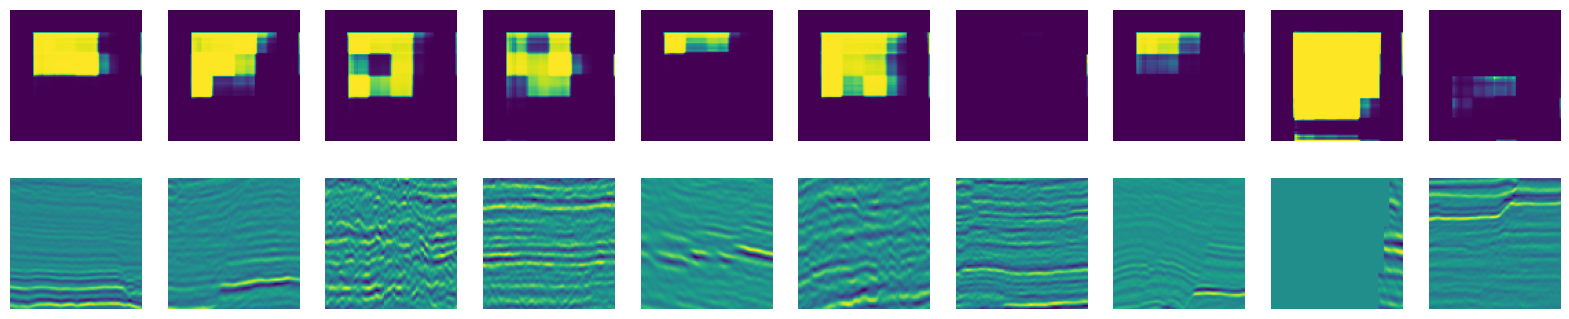

In [14]:
display_sample_images(y_preds, test_dataset[0],(96,96))

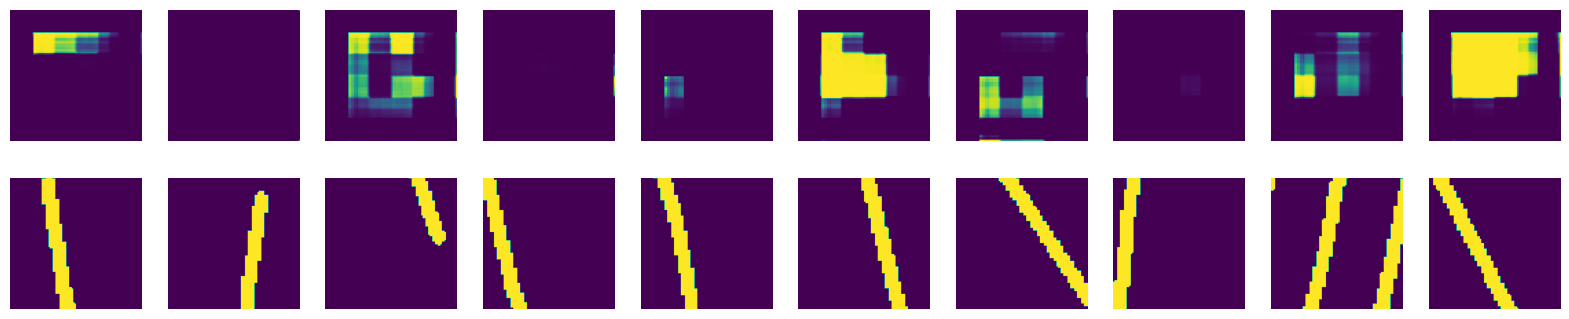

In [15]:
display_sample_images(y_preds, test_dataset[1],(96,96))